# Inference Analysis

In this notebook we're looking at the statistical significance of distribution differences between audio features of hits versus non-hits. This is not testing all features, only those that seemed relevant for the model built in the EDA notebook.

In [4]:
import pandas as pd

# Import Data
train = pd.read_csv('../data/processed/train.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])

hits = train.loc[train.hit == True,:].copy()
nhits = train.loc[train.hit == False,:].copy()

In [44]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Random
np.random.seed(500)

# Set default for figure sizes
mlp.rcParams['figure.figsize'] = (16,6)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

Z-tests are so-called "robust tests", which means that since we're comparing the distributions of means which tend to be normally distributed we don't necessarily need normality in the data. Nevertheless, it gives some reassurance to know that we're dealing with a normal distribution.

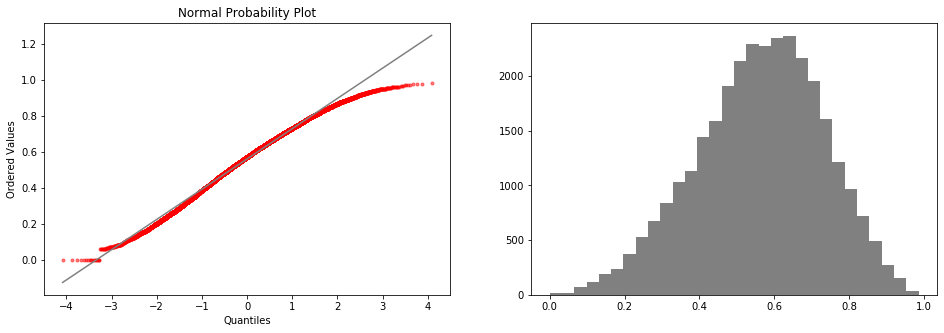

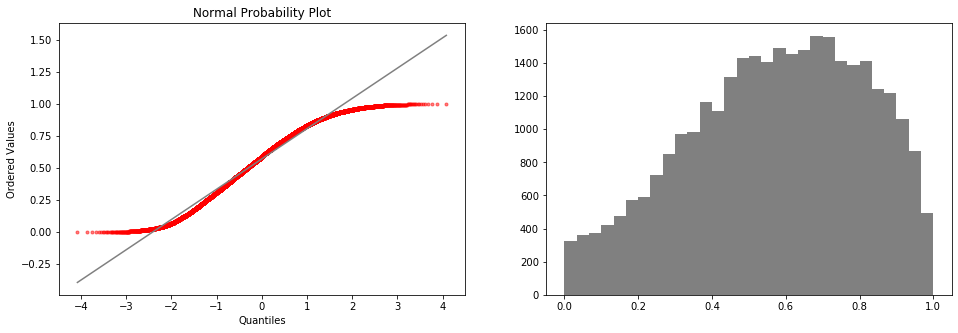

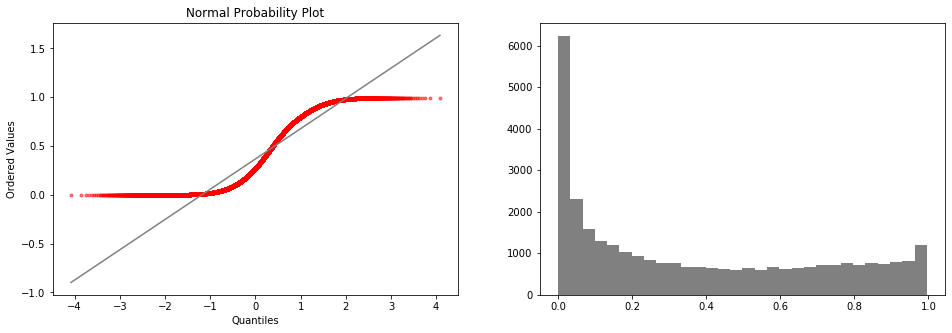

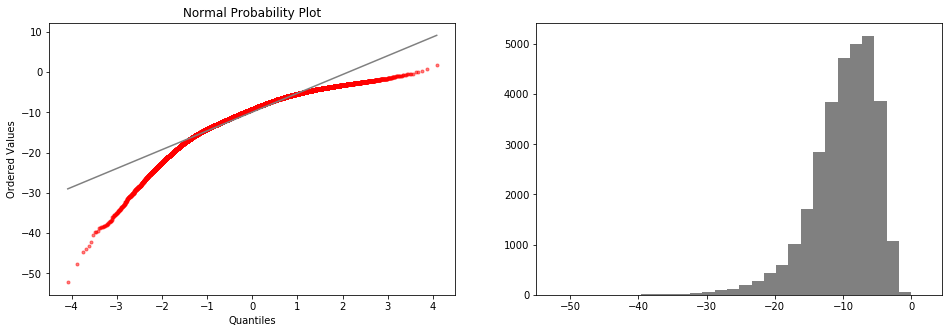

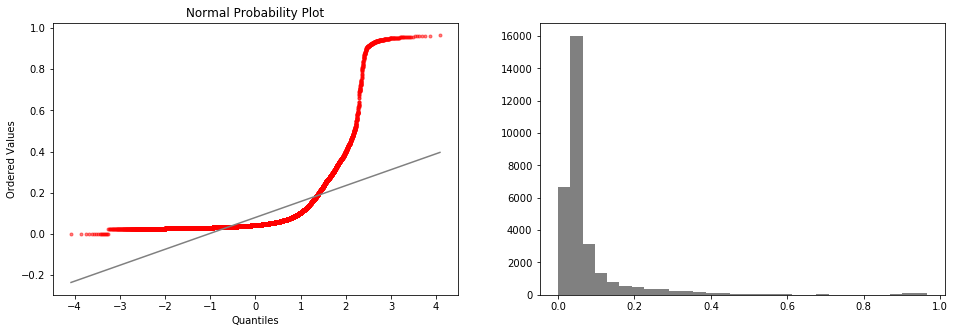

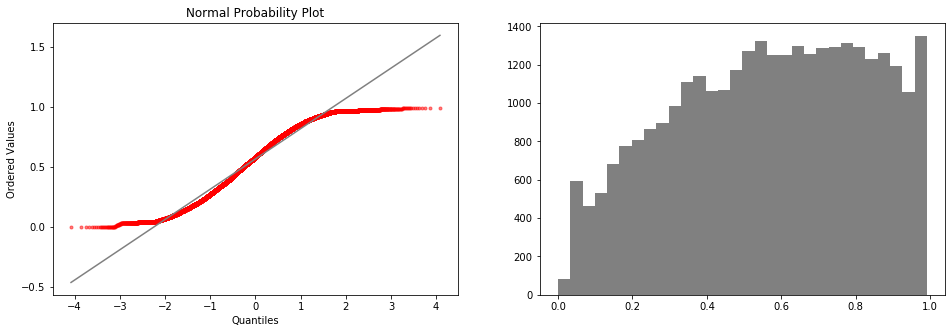

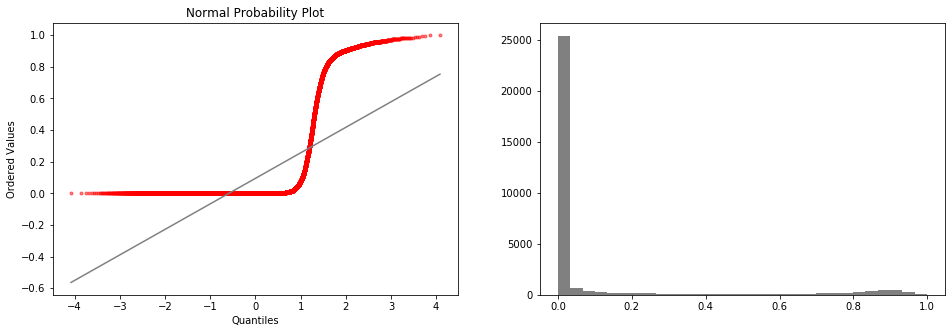

In [40]:
import pylab 
import scipy.stats as stats

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)

qq_plot(train['danceability'])
qq_plot(train['energy'])
qq_plot(train['acousticness'])
qq_plot(train['loudness'])
qq_plot(train['speechiness'])
qq_plot(train['valence'])
qq_plot(train['instrumentalness'])

plt.show()

Unfortunately, we're not dealing with normal distributions in this case. We'll see that normality is achieved by using the mean difference with permutations in the following plots.

# Danceability Distribution

To better understand whether the distributions are statistically significantly different we'll use a Z-Test.

    H0: The Danceability Distribution for Hits and Non-Hits is the same (i.e. the mean diff is 0).
    H1: The Danceability Distribution for Hits and Non-Hits is not the same.
    alpha = 0.05

Hits Mean: 0.5957135504885993
Non-Hits Mean: 0.5295059136044526
Mean Diff: 0.06620763688414666
H0 Diff: 0


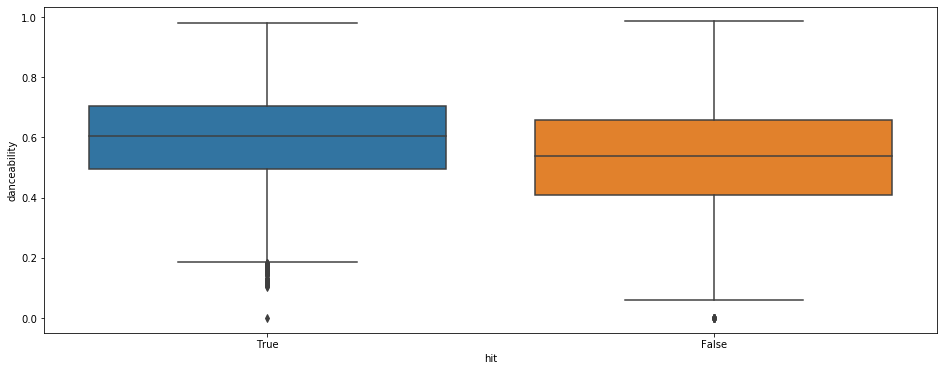

p: 0.0
CI: [-0.00384252  0.0037603 ]
ME: 0.003786297754012112


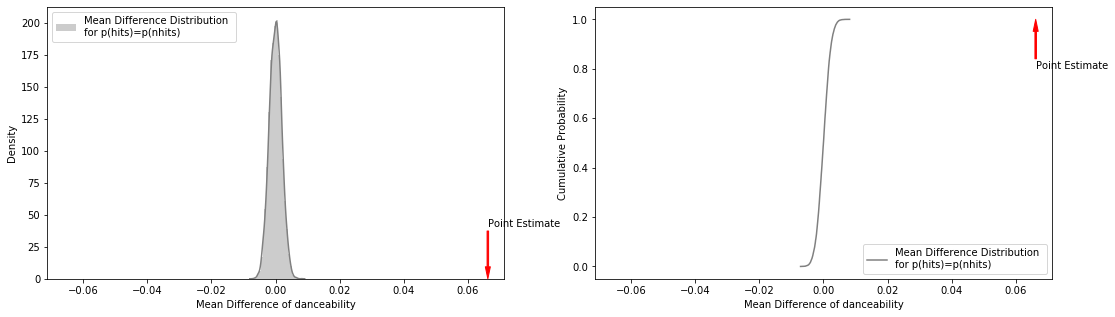

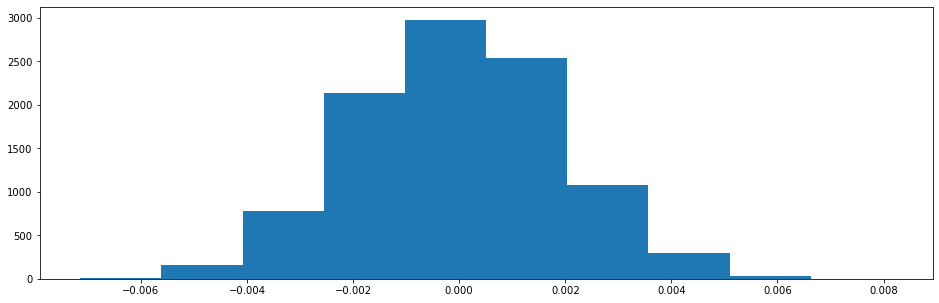

In [43]:
hits_danceability = hits.danceability.dropna()
nhits_danceability = nhits.danceability.dropna()

hits_nhits_diff = hits_danceability.mean() - nhits_danceability.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.danceability.mean(), nhits.danceability.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='danceability',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_danceability,nhits_danceability,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of danceability between Hits and Non-Hits are statistically significant.

# Energy Distribution

Hits Mean: 0.6176291400651467
Non-Hits Mean: 0.5279292037126051
Mean Diff: 0.08969993635254148
H0 Diff: 0


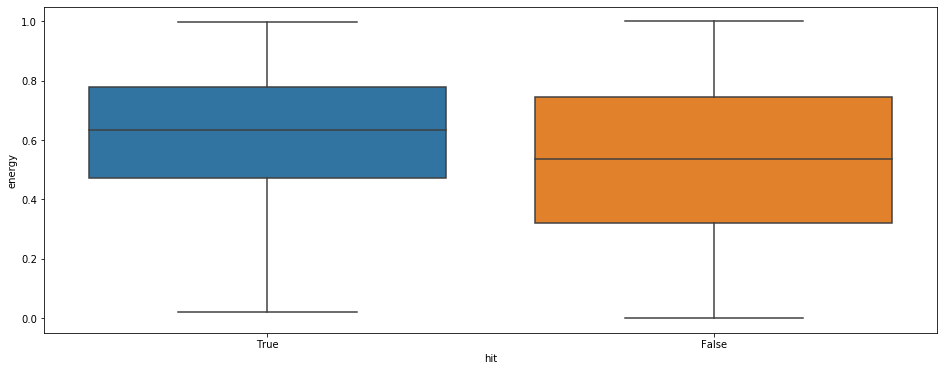

p: 0.0
CI: [-0.00529925  0.00529784]
ME: 0.0052706339612379974


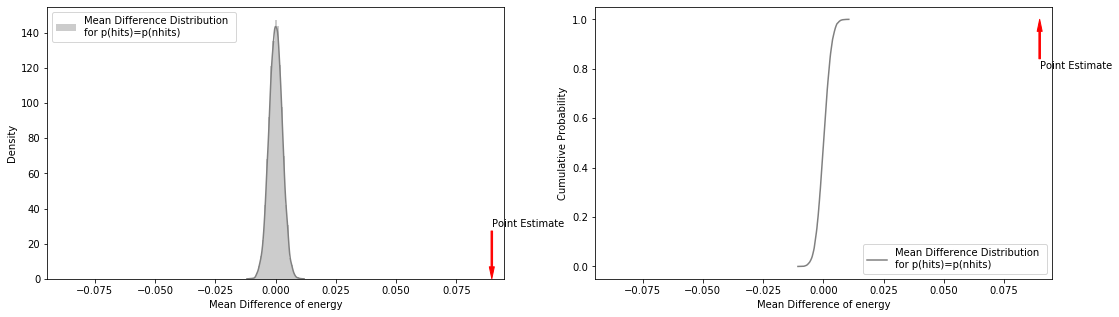

In [7]:
hits_energy = hits.energy.dropna()
nhits_energy = nhits.energy.dropna()

hits_nhits_diff = hits_energy.mean() - nhits_energy.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.energy.mean(), nhits.energy.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='energy',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_energy,nhits_energy,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of energy between Hits and Non-Hits are statistically significant.

# Acousticness Distribution

Hits Mean: 0.2987878794723128
Non-Hits Mean: 0.43604737878122823
Mean Diff: -0.13725949930891557
H0 Diff: 0


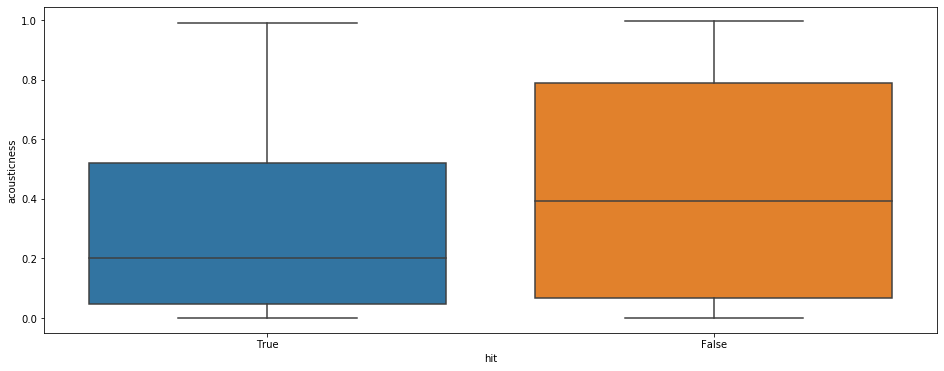

p: 0.0
CI: [-0.00721202  0.0073153 ]
ME: 0.007284816371499915


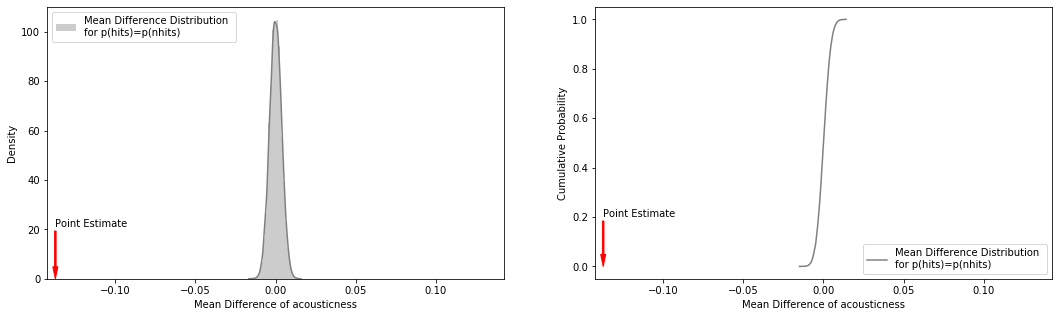

In [8]:
hits_acousticness = hits.acousticness.dropna()
nhits_acousticness = nhits.acousticness.dropna()

hits_nhits_diff = hits_acousticness.mean() - nhits_acousticness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.acousticness.mean(), nhits.acousticness.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='acousticness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_acousticness,nhits_acousticness,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of acousticness between Hits and Non-Hits are statistically significant.

# Loudness Distribution

Hits Mean: -8.802725342019542
Non-Hits Mean: -11.022258743912465
Mean Diff: 2.219533401892921
H0 Diff: 0


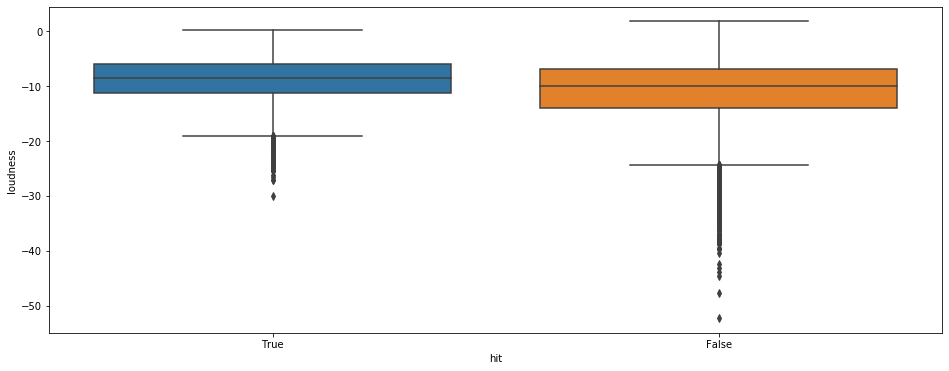

p: 0.0
CI: [-0.10930742  0.10737263]
ME: 0.10754372215492851


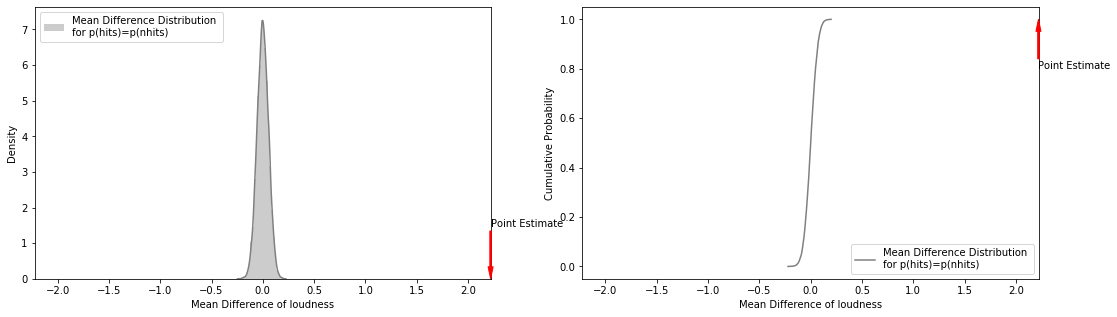

In [9]:
hits_loudness = hits.loudness.dropna()
nhits_loudness = nhits.loudness.dropna()

hits_nhits_diff = hits_loudness.mean() - nhits_loudness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.loudness.mean(), nhits.loudness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='loudness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_loudness,nhits_loudness,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of loudness between Hits and Non-Hits are statistically significant.

# Speechiness Distribution

Hits Mean: 0.06883432573289902
Non-Hits Mean: 0.09073435582822086
Mean Diff: -0.02190003009532182
H0 Diff: 0


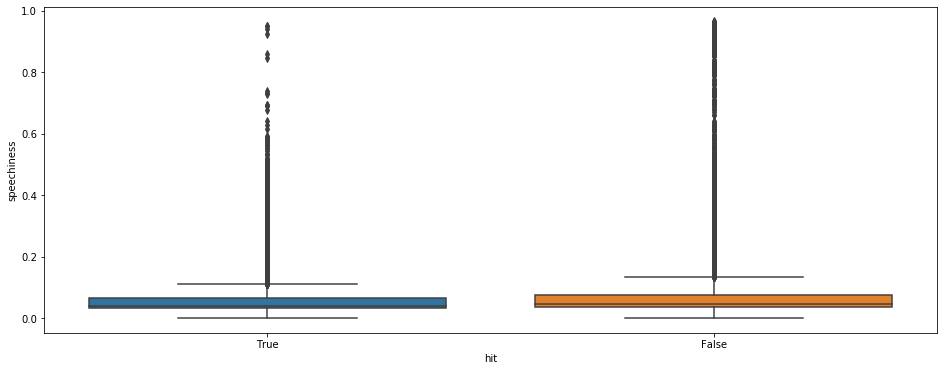

p: 0.0
CI: [-0.00259367  0.00254747]
ME: 0.0025622984089145925


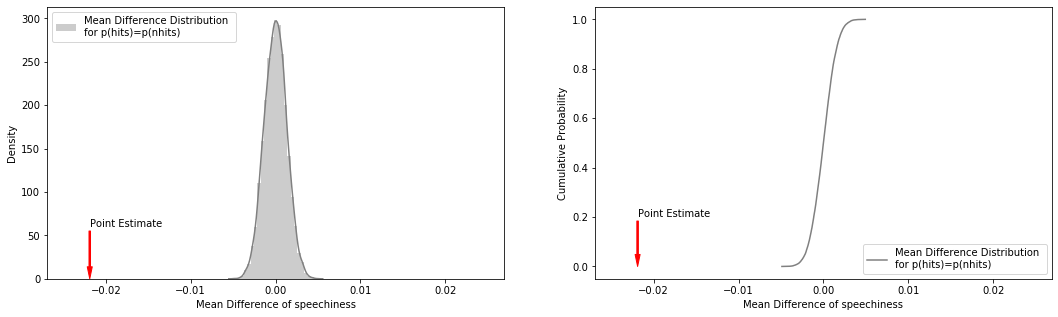

In [10]:
hits_speechiness = hits.speechiness.dropna()
nhits_speechiness = nhits.speechiness.dropna()

hits_nhits_diff = hits_speechiness.mean() - nhits_speechiness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.speechiness.mean(), nhits.speechiness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='speechiness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_speechiness,nhits_speechiness,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of speechiness between Hits and Non-Hits are statistically significant.

# Valence Distribution

Hits Mean: 0.6109236091205211
Non-Hits Mean: 0.5214109423818861
Mean Diff: 0.08951266673863512
H0 Diff: 0


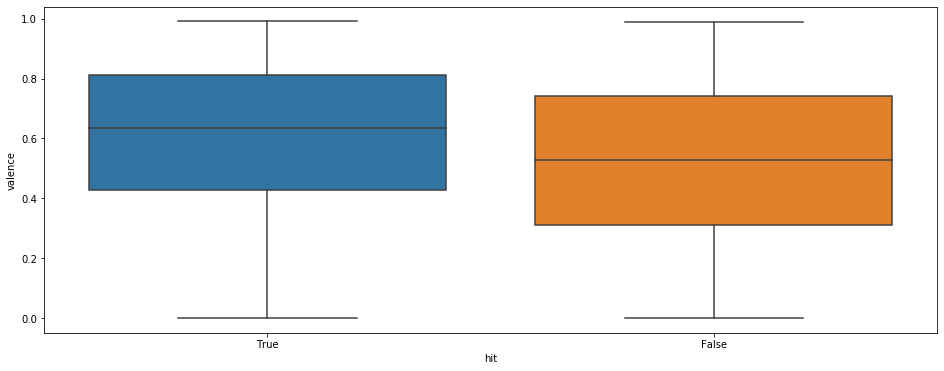

p: 0.0
CI: [-0.00564663  0.00565781]
ME: 0.005637536012795978


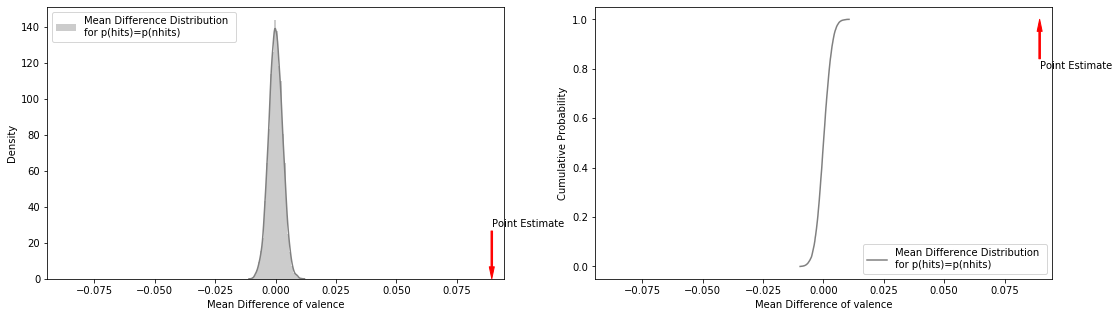

In [11]:
hits_valence = hits.valence.dropna()
nhits_valence = nhits.valence.dropna()

hits_nhits_diff = hits_valence.mean() - nhits_valence.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.valence.mean(), nhits.valence.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='valence',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_valence,nhits_valence,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of valence between Hits and Non-Hits are statistically significant.

# Instrumentalness Distribution

Hits Mean: 0.03421712542280131
Non-Hits Mean: 0.15391891948833092
Mean Diff: -0.11970179406552961
H0 Diff: 0


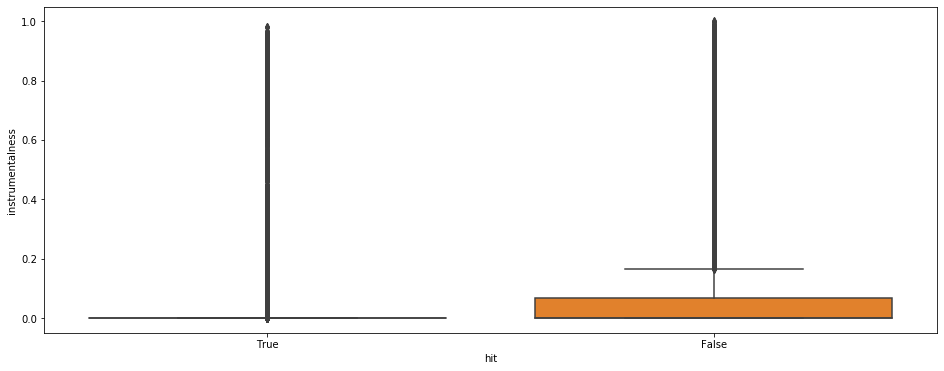

p: 0.0
CI: [-0.00538823  0.00536935]
ME: 0.005406550823514688


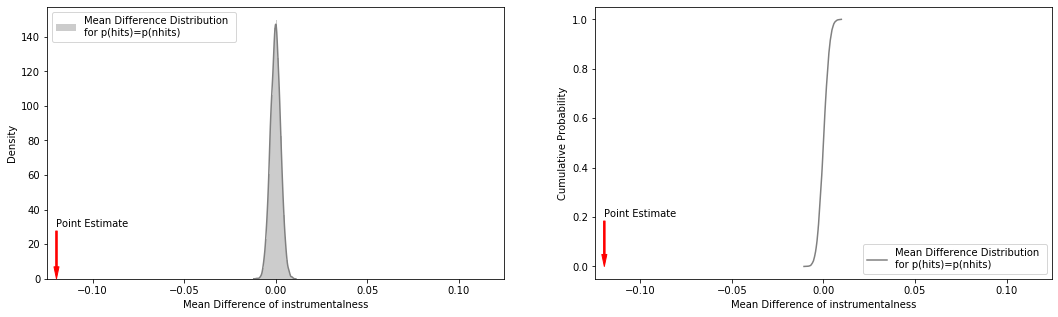

In [12]:
hits_instrumentalness = hits.instrumentalness.dropna()
nhits_instrumentalness = nhits.instrumentalness.dropna()

hits_nhits_diff = hits_instrumentalness.mean() - nhits_instrumentalness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.instrumentalness.mean(), nhits.instrumentalness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='instrumentalness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_instrumentalness,nhits_instrumentalness,hits_nhits_diff)

We can reject H0 for alpha = 0.001 and have gathered evidence that the distributions of valence between Hits and Non-Hits are statistically significant.